In [1]:
######################################################
# load my model and history
######################################################
import pickle
from keras.models import load_model

# Cargar el modelo
model = load_model('/content/drive/MyDrive/Colab Notebooks/model_resize_15-15.h5')

# Cargar la lista de historias
with open('/content/drive/MyDrive/Colab Notebooks/histories_resize_15-15.pkl', 'rb') as file:
    history_list = pickle.load(file)


In [2]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 64

test_data_generator = ImageDataGenerator(
    preprocessing_function = preprocess_input)

test_generator = test_data_generator.flow_from_directory(directory="/content/drive/MyDrive/Colab Notebooks/Test_original",
                                                         class_mode ="sparse",
                                                        target_size = (224 , 224),
                                                        batch_size = batch_size,
                                                        shuffle=False)
class_names = list(test_generator.class_indices.keys())

Found 1113 images belonging to 12 classes.


In [3]:
print(class_names)

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherd Purse', 'Small-flowered Cranesbill', 'Sugar beet']


In [3]:
import os
import cv2
import numpy as np

def load_data(path, class_names = class_names):
    img_list = []
    label_list = []
    for i in range(12):
        PATH = os.path.join(path,class_names[i])+'/'
        for filename in os.listdir(PATH):
            img=cv2.imread(os.path.join(PATH,filename))
            # Resize image
            img=cv2.resize(img,(224,224))
            # for the black and white image
            if img.shape==(224, 224):
                img=img.reshape([224,224,1])
                img=np.concatenate([img,img,img],axis=2)
            # cv2 load the image BGR sequence color (not RGB)
            img_list.append(img[...,::-1])
            label_list.append(i+1)
    return np.array(img_list), np.array(label_list)

# Load the images train
X_train, Y_train = load_data(path = '/content/drive/MyDrive/Colab Notebooks/Train_original')

# Load the images test
X_test, Y_test = load_data(path = '/content/drive/MyDrive/Colab Notebooks/Test_original')

In [4]:
from sklearn.svm import SVC
from tensorflow.keras.models import Model, Sequential

intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[2].output)
X_train_features = intermediate_layer_model.predict(preprocess_input(X_train))
X_test_features = intermediate_layer_model.predict(preprocess_input(X_test))

svm = SVC(C=100)

svm.fit(X_train_features, Y_train)
svm.score(X_test_features, Y_test)

35/35 [==============================] - 8s 229ms/step


0.9398023360287511

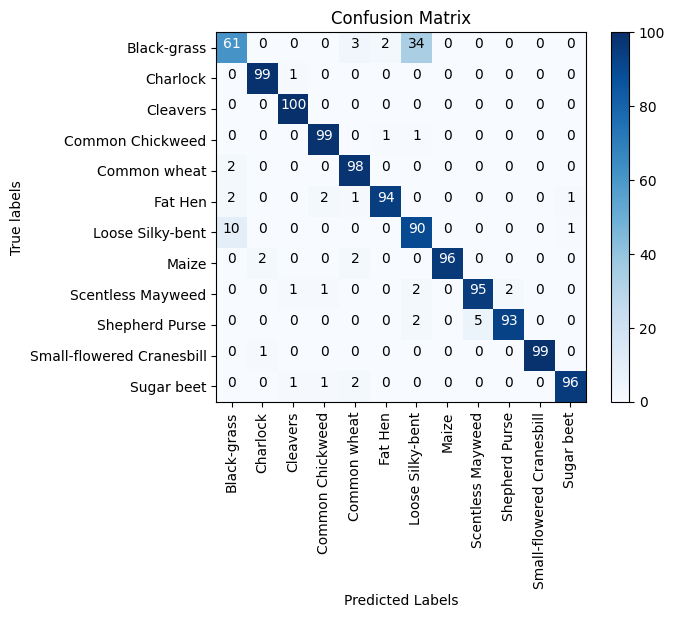

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import itertools
import matplotlib.pyplot as plt

predictions = svm.predict(X_test_features)

# Obtener la matriz de confusión
cm = confusion_matrix(Y_test, predictions)
# Normalize the confusion matrix to show percentages
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

classes = class_names

plt.figure()

plt.imshow(cm, interpolation='nearest',cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]:0.0f}",  # Display percentage value
             horizontalalignment="center",
             color="white" if cm[i, j] > ( cm.max() / 2) else "black")

plt.ylabel('True labels')
plt.xlabel('Predicted Labels')
plt.show()